<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/EEG_analysis_program_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install mne

In [14]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# EDFファイルの読み込み
edf_file = '/content/tarumi_20220208_20220208_020512_ref_fil.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True)

# データのフィルタリング
# 例: バンドパスフィルタを適用 (0.5-20 Hz)
raw.filter(3, 20, fir_design='firwin')

# ノイズリダクション
# 例: ICA (独立成分解析) を使用してアーティファクトを検出・除去
ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
ica.fit(raw)
raw = ica.apply(raw)

# エポックデータに分割
event_id = 1  # イベントIDを設定
events = mne.make_fixed_length_events(raw, event_id, duration=1.0)
epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=1.0, baseline=None, preload=True)

# サンプリング周波数を取得
sfreq = epochs.info['sfreq']


Extracting EDF parameters from /content/tarumi_20220208_20220208_020512_ref_fil.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 941249  =      0.000 ...  3764.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.8s


Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 117.0s.
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Not setting metadata
3765 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3765 events and 251 original time points ...
1 bad epochs dropped


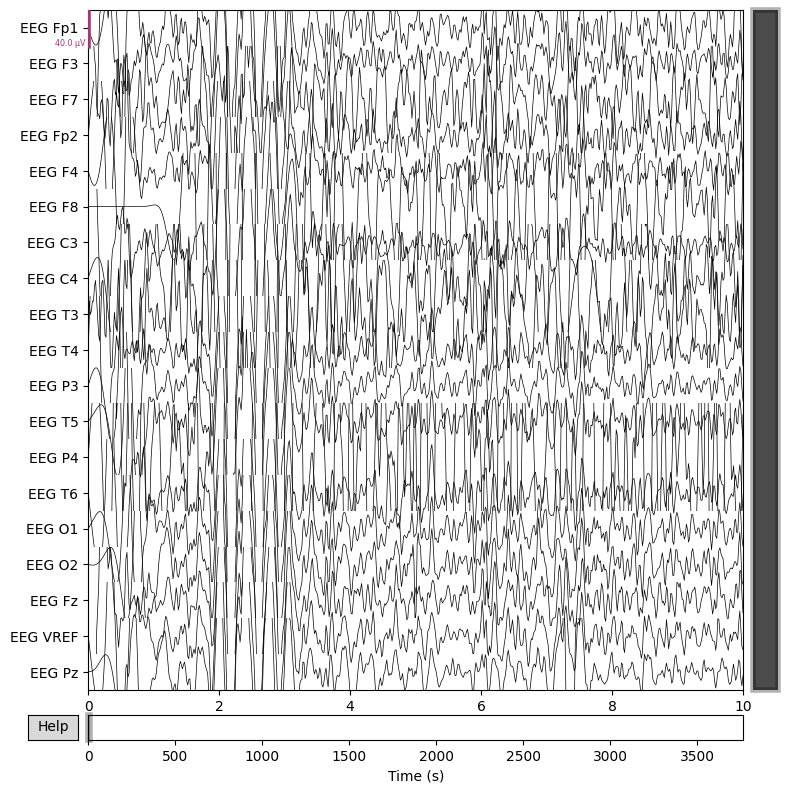

In [15]:
# プロットサイズを調整して脳波データをプロット
fig = raw.plot()
fig.set_size_inches(200, 120)  # 幅10インチ、高さ6インチに設定
plt.show()  # プロットを表示

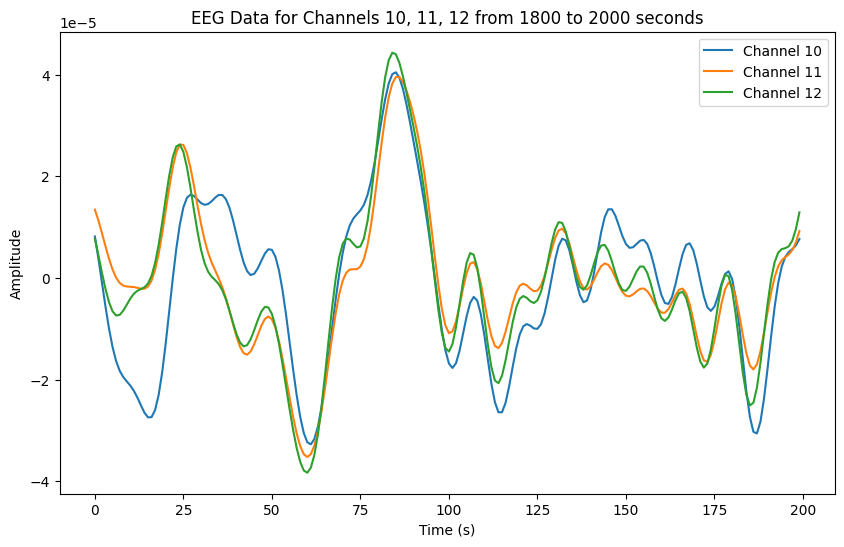

In [26]:
import matplotlib.pyplot as plt

# チャンネルの選択（複数のチャンネルを指定）
channel_numbers = [9, 10, 11]  # プロットしたいチャンネルの番号をリストで指定

# 時間帯の選択（start_timeとend_timeを指定）
start_time = 1800.0  # 開始時間（秒）
end_time = 2000.0  # 終了時間（秒）

# 整数に変換
start_time = int(start_time)
end_time = int(end_time)

# プロットしたいデータを抽出
selected_data = raw.get_data(start=start_time, stop=end_time)

# プロットの設定
plt.figure(figsize=(10, 6))  # プロットサイズを設定

# 選択した各チャンネルをプロット
for i, channel_number in enumerate(channel_numbers):
    plt.plot(selected_data[channel_number], label=f'Channel {channel_number + 1}')

plt.xlabel('Time (s)')  # X軸ラベル
plt.ylabel('Amplitude')  # Y軸ラベル
plt.title(f'EEG Data for Channels {", ".join([str(cn + 1) for cn in channel_numbers])} from {start_time} to {end_time} seconds')  # タイトル
plt.legend()  # 凡例を表示

# プロットを表示
plt.show()

In [ ]:
# データに含まれるチャンネル名を取得
channel_names = raw.ch_names

# チャンネル名を表示
print(channel_names)

['EEG Fp1', 'EEG F3', 'EEG F7', 'EEG Fp2', 'EEG F4', 'EEG F8', 'EEG C3', 'EEG C4', 'EEG T3', 'EEG T4', 'EEG P3', 'EEG T5', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG VREF', 'EEG Pz']


In [ ]:
# マークされた邪魔なチャンネルのリストを作成
exclude_chans = ['EEG P4', 'EEG T6', 'EEG Fp1']

# チャンネルのピッキング（選択）
raw.pick(picks=[ch for ch in raw.ch_names if ch not in exclude_chans])

# プロットサイズを調整して脳波データをプロット
fig = raw.plot()
fig.set_size_inches(10, 6)  # 幅10インチ、高さ6インチに設定
plt.show()  # プロットを表示

ValueError: ignored

Effective window size : 1.004 (s)


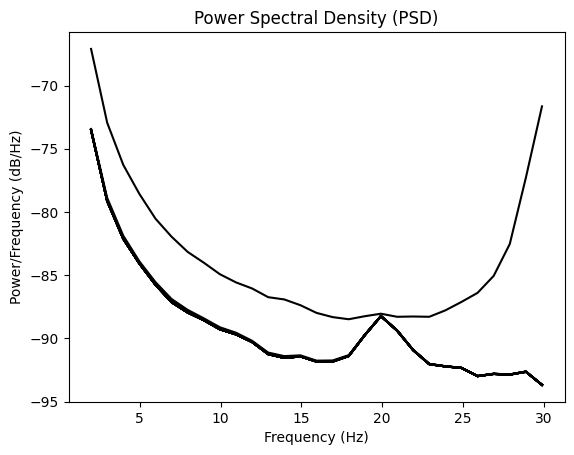

In [ ]:
# 周波数解析 (psd_array_welchを使用)
fmin, fmax = 1, 30  # 分析したい周波数帯域を指定 (ここでは1-30 Hz)
n_fft = 251  # 信号の長さ以下の値を設定
psds, freqs = mne.time_frequency.psd_array_welch(epochs.get_data(), sfreq=sfreq, fmin=fmin, fmax=fmax, n_fft=n_fft, n_jobs=1)

# エポック間でPSDの平均を計算する（最初の軸に沿って平均化）
mean_psds = 10 * np.log10(psds.mean(0))

# 'mean_psds' の寸法を (29, 19) に変更
mean_psds = mean_psds.T

# プロット
plt.figure()
plt.plot(freqs, mean_psds, color='k')
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()
